In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [18]:
seqs = [s for s in fasta_iter(human, returnheader=False)]

In [9]:
entropyestimator = lambda x: entropy_grassberger(x, base=2)
def calc_mi(df2):
    entropy2 = entropyestimator(df2['count'])
    df = strcolumn_to_charcolumns(df2, 'seq')
    e1 = entropyestimator(df.groupby('aa1').agg(np.sum)['count'])
    e2 = entropyestimator(df.groupby('aa2').agg(np.sum)['count'])
    mi = e1 + e2 - entropy2
    return mi

In [67]:
def calc_mi_direct(df2):
    strcolumn_to_charcolumns(df2, 'seq')
    df11 = df2.groupby('aa1').agg(np.sum)['count']
    df11 /= np.sum(df11)
    df12 = df2.groupby('aa2').agg(np.sum)['count']
    df12 /= np.sum(df12)
    df2['theory'] = [float(df11.loc[s[0]] * df12.loc[s[1]]) for s in df2['seq']]
    df2['freq'] = df2['count']/np.sum(df2['count'])
    mi = np.sum(df2['freq']*np.log2(df2['freq']/df2['theory']))
    micorr = mi - (len(aminoacids)-1)**2/(2*np.log(2)*np.sum(df2['count']))
    return mi, micorr

In [88]:
mis1000direct = []
for i in range(100):
    df2 = Counter(random.sample(seqs, 1000), k=2, gap=0).to_df(norm=False, clean=True)
    mis1000direct.append(calc_mi_direct(df2)[0])

In [89]:
mis1000tp = []
for i in range(100):
    df2 = Counter(random.sample(seqs, 1000), k=2, gap=0).to_df(norm=False, clean=True)
    mis1000tp.append(calc_mi_direct(df2)[1])

In [34]:
mis1000 = []
for i in range(100):
    df2 = Counter(random.sample(seqs, 1000), k=2, gap=0).to_df(norm=False, clean=True)
    mis1000.append(calc_mi(df2))

In [90]:
mis10000 = []
for i in range(100):
    df2 = Counter(random.sample(seqs, 10000), k=2, gap=0).to_df(norm=False, clean=True)
    mis10000.append(calc_mi(df2))

In [96]:
mis10000tp = []
for i in range(100):
    df2 = Counter(random.sample(seqs, 10000), k=2, gap=0).to_df(norm=False, clean=True)
    mis10000tp.append(calc_mi_direct(df2)[1])

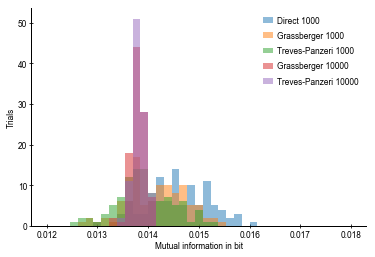

In [97]:
bins = np.linspace(0.012, 0.018, 40)
histkwargs = dict(bins=bins, alpha=.5)
plt.hist(mis1000direct, label='Direct 1000', **histkwargs)
plt.hist(mis1000, label='Grassberger 1000', **histkwargs)
plt.hist(mis1000tp, label='Treves-Panzeri 1000', **histkwargs)
plt.hist(mis10000, label='Grassberger 10000', **histkwargs)
plt.hist(mis10000tp, label='Treves-Panzeri 10000', **histkwargs)
plt.legend()
plt.xlabel('Mutual information in bit')
plt.ylabel('Trials')
plt.savefig('main.png')

In [105]:
(np.var(mis10000tp)/2)**.5, (np.var(mis10000)/2)**.5, np.mean(mis1000tp), np.mean(mis1000), np.mean(mis1000direct), np.mean(mis10000tp)



(8.784540191731597e-05,
 9.933132660407625e-05,
 0.013923277224254078,
 0.014171496114031523,
 0.01459815707463865,
 0.013819447714298033)